In [169]:
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [170]:
# Suprimir avisos
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [171]:
df = pd.read_csv('../dataset/dataset_simulado.csv')

In [172]:
# Pré-processamento: Criar uma coluna "inconsistente" para tratar inconsistências
def marcar_inconsistencias(row):
    erros = 0
    # Idade inválida (outliers)
    if pd.isnull(row['Idade']) or row['Idade'] < 0 or row['Idade'] > 100:
        erros += 1
    # Salário inválido (outliers)
    if pd.isnull(row['Salário']) or row['Salário'] <= 0 or row['Salário'] > 50000:
        erros += 1
    # Formato de data inválido
    try:
        pd.to_datetime(row['Data_Nascimento'], format="%Y-%m-%d")
    except ValueError:
        erros += 1
    # E-mail inválido
    if '@' not in row['Email']:
        erros += 1
    return 1 if erros > 0 else 0

df['Inconsistente'] = df.apply(marcar_inconsistencias, axis=1)


In [173]:
# Separar features (X) e target (y)
X = df[['Idade', 'Salário']].fillna(-1)  # Usar valores padrão para valores nulos
y = df['Inconsistente']  # Classe a ser predita (0 = consistente, 1 = inconsistente)

# Definir o MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(10,),  # 10 neurônios, 1 camada oculta
                    activation='relu',
                    solver='adam',
                    batch_size='auto',
                    learning_rate_init=0.000098,
                    momentum=0.9,
                    early_stopping=True,
                    max_iter=1,
                    warm_start=True,
                    random_state=42)


In [174]:
# Definir KFold para cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Listas para armazenar erros
train_errors = []
val_errors = []

# Definir o número de épocas
n_epochs = 100

In [175]:
# Treinar o modelo com validação cruzada manualmente
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_error_fold = []
    val_error_fold = []

    for epoch in range(n_epochs):
        mlp.fit(X_train, y_train)

        y_train_pred = mlp.predict(X_train)
        y_val_pred = mlp.predict(X_val)

        train_error = 1 - accuracy_score(y_train, y_train_pred)
        val_error = 1 - accuracy_score(y_val, y_val_pred)

        train_error_fold.append(train_error)
        val_error_fold.append(val_error)

    train_errors.append(train_error_fold)
    val_errors.append(val_error_fold)

# Converter listas em arrays para facilitar o cálculo da média
train_errors = np.array(train_errors)
val_errors = np.array(val_errors)

In [176]:
# Média dos erros em todos os folds
mean_train_errors = np.mean(train_errors, axis=0)
mean_val_errors = np.mean(val_errors, axis=0)

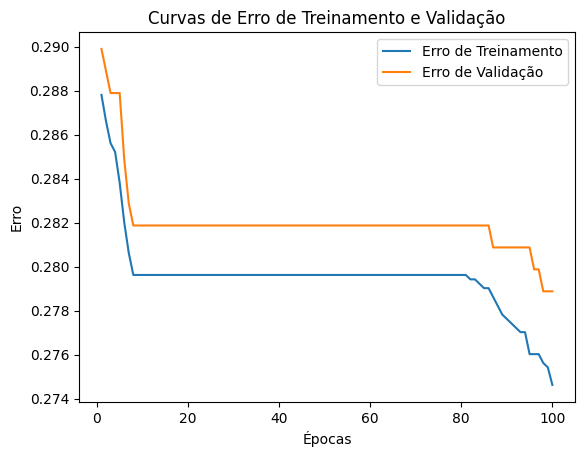

Acurácia: 0.694
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       662
           1       1.00      0.09      0.17       338

    accuracy                           0.69      1000
   macro avg       0.84      0.55      0.49      1000
weighted avg       0.79      0.69      0.60      1000

Acurácias em cada fold: [0.73652695 0.68263473 0.66467066 0.65868263 0.74698795 0.6746988 ]
Média de acurácias: 0.694033619507972


In [177]:
# Plotar as curvas de erro
plt.plot(range(1, n_epochs+1), mean_train_errors, label='Erro de Treinamento')
plt.plot(range(1, n_epochs+1), mean_val_errors, label='Erro de Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.title('Curvas de Erro de Treinamento e Validação')
plt.legend()
plt.show()

# Avaliação final com cross-validation
y_pred = cross_val_predict(mlp, X, y, cv=kf)
accuracy = accuracy_score(y, y_pred)
classification_rep = classification_report(y, y_pred)

print(f"Acurácia: {accuracy}")
print("Relatório de Classificação:")
print(classification_rep)

cv_scores = cross_val_score(mlp, X, y, cv=kf)
print(f"Acurácias em cada fold: {cv_scores}")
print(f"Média de acurácias: {np.mean(cv_scores)}")